In [155]:
# Plot colors
lblue="#a6cee3"
blue = "#1f78b4"
lgreen = "#b2df8a"
green = "#33a02c"
black= "#424242"


from os import path, remove
import sys
import subprocess
from subprocess import call,check_output, DEVNULL
from pandas import read_csv
from os import path
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def validate_args(datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    if recordSizeBytes not in [8,32,128]:
        print("The valid record size options are 8,32,128")
        exit()

# Adds a experiment to the tsv configuration file. Each experiment described the dataset 
# that is going to be searched and which search algorithm is going to be used.
# Input Args:
#             tsvpath: the path of the tsvfile
#             datasetSize: number of records of the dataset to be searched
#             distribution: distribution of the keys of the dataset to be searched
#             parameter:    datasets parameter
#             searchAlgo: name of the search algorithm to use
#             recordSizeBytes: size of record (key + payload)
#             nThreads: number of threads to be used for search
def add_to_tsv(tsvpath, datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    validate_args(datasetSize, distribution, parameter,searchAlgo, recordSizeBytes, nThreads)
    if not path.exists(tsvpath):
        with open(tsvpath, "w") as f:
            f.write("DatasetSize\tDistribution\tParameter\tSearchAlgorithm\tRecordSizeBytes\t#threads\n")
#     if parameter is "":
#         parameter = parameterMap[distribution]
#     distribution = paperToBenchmarkDistributionNames[distribution]
    with open(tsvpath, "a") as f:
        conf = str(datasetSize)+"\t"+ \
               str(distribution)+"\t"+ \
               str(parameter)+"\t"+ \
               str(searchAlgo)+"\t"+ \
               str(recordSizeBytes)+"\t"+ \
               str(nThreads)+"\n"
        f.write(conf)
    
def rm_tsv(tsvpath):
    if path.exists(tsvpath):
        remove(tsvpath)

def UaR_to_tsv(tsvpath, datasetSize, searchAlgo, recordSizeBytes, nThreads, parameter=42):
    add_to_tsv(tsvpath, datasetSize, "uniform", parameter, searchAlgo, recordSizeBytes, nThreads)
    
def fbids_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/fb/fb-289000.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq1_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/wiki.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq2_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/newman.txt", searchAlgo, recordSizeBytes, nThreads)

def fal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "fal", parameter, searchAlgo, recordSizeBytes, nThreads)

def cfal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "cfal", parameter, searchAlgo, recordSizeBytes, nThreads)

def gap_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, random_seed, shape, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "gap", str(random_seed)+","+str(shape), searchAlgo, recordSizeBytes, nThreads)
    

In [171]:
def run(tsvname):
#     run_params = ['Run','DatasetSize','Distribution','Parameter','#threads','SearchAlgorithm','RecordSizeBytes']

    resultFile=tsvname+".out"
    if path.exists(resultFile):
        print("This tsv has been already executed and the results have been saved.")
        print("If you want to rerun the experiments please delete the file: "+tsvname+".out")
    else:
        with open(resultFile, "w") as log_file:
            subprocess.run(["python3","./getTimes.py","./replicate_experiments/"+tsvname], stdout=log_file, stderr=DEVNULL, cwd="../") 

In [172]:
import csv

def get_results(tsvname):
    times=[]
    with open(tsvname+".out", newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\t')
        for row in csvreader:
            if len(row)>0 and row[0][0].isdigit():
                times.append(float(row[0].split()[7]))
    return times


#### Figure 2

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig2.tsv.out


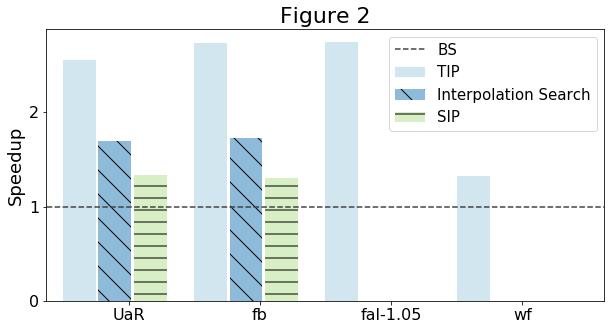

In [170]:
tsv = "fig2.tsv"
rm_tsv(tsv)

# TODO(faster)
size=5 #8
for algorithm in ["bs", "sip", "is", "tip"]:
    UaR_to_tsv(tsv, 10**size, algorithm, 8, 1)
    
for algorithm in ["bs", "sip", "is", "tip"]:
    fbids_to_tsv(tsv, algorithm, 8, 1) 
    
for algorithm in ["bs", "tip"]:
    fal_to_tsv(tsv, algorithm, 8, 1, 1.05, 10**size) 

for algorithm in ["bs", "tip"]:
    freq1_to_tsv(tsv, algorithm, 8, 1)

run(tsv)
results=get_results(tsv)
# print(results)

# X: dataset
# Y: Speedup with BS

uarResults=results[0:4]
fbidsResults=results[4:8]
falResults=results[8:10]
freq1Results=results[10:12]

# Calculate speedups of sip, is and tip compard to Binary Search
uarSpeedups = []
for i in range(1,len(uarResults)):
    uarSpeedups.append(uarResults[0]/uarResults[i])

fbidsSpeedups = []
for i in range(1,len(fbidsResults)):
    fbidsSpeedups.append(fbidsResults[0]/fbidsResults[i])

falSpeedups = []
for i in range(1,len(falResults)):
    falSpeedups.append(falResults[0]/falResults[i])
    
freq1Speedups = []
for i in range(1,len(freq1Results)):
    freq1Speedups.append(freq1Results[0]/freq1Results[i])

    
# Plot

# Group the speedups of each algorithm
tipSpeedups=[uarSpeedups[0], fbidsSpeedups[0], falSpeedups[0], freq1Speedups[0]]
ISSpeedups=[uarSpeedups[1], fbidsSpeedups[1],0,0]
sipSpeedups=[uarSpeedups[2], fbidsSpeedups[2],0,0]

labels=["UaR", "fb", "fal-1.05", "wf"]
pos = [0,1,2,3]
width = 0.25 

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, 
        tipSpeedups, 
        width, 
        alpha=0.5, 
        color=lblue, 
        label="TIP") 

plt.bar([p + width+.02 for p in pos], 
        ISSpeedups,
        width, 
        alpha=0.5, 
        color=blue, 
        label="Interpolation Search",
        hatch="\\") 

plt.bar([p + width*2+.04 for p in pos], 
        sipSpeedups,
        width, 
        alpha=0.5, 
        color=lgreen, 
        label="SIP",
        hatch="-") 

plt.plot([-1,5],[1,1],linestyle="dashed", color=black, label="BS")

ax.set_ylabel('Speedup', size=18)

ax.set_title('Figure 2', size=22)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set the labels for the x ticks
ax.set_xticklabels(labels, size=15)
ax.tick_params(axis='both', which='major', labelsize=16)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['TIP', 'Interpolation Search', 'SIP'], loc='upper right')
plt.legend(prop={'size': 15})
plt.show()


#### Figure 5

In [84]:
# algos: i-hyp-64, i-opt-8, bs
# datasets: fb
# record-size: 8,32,128

tsv="fig5.tsv"
rm_tsv(tsv)

for recordSize in [8,32,128]:
    for algorithm in ["sip", "bs", "tip", "is"]:
        fbids_to_tsv(tsv, algorithm, recordSize, 1)

run(tsv)
results=get_results(tsv)
print(results)

# X: Record size
# Y: Time

[48.148204, 118.598478, 93.895588, 68.949225, 74.637879, 175.712907, 147.725952, 110.905779, 150.933875, 300.352768, 297.474913, 238.099896]


#### Figure 6

In [85]:
# algos: i-opt-8, bs
# datasets: UaR
# record-size: 8,32,128
    

tsv="fig6.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#,6,7,8,9]:
    for algorithm in ["bs", "sip"]:
        for recordSize in [8,32,128]:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, recordSize, 1)   
            
run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records
# Y: Speedup vs bs


[34.41, 39.233, 67.292, 21.758, 23.51, 26.242, 55.0165, 68.2301, 89.2553, 23.2916, 28.5483, 37.424, 88.05029, 105.98358, 154.8023, 36.48282, 45.05727, 84.84596]


#### Figure 7

In [86]:
# algos: i-opt-8, bs
# datasets: UaR(10^3 - 10^9)
# record-size: 32
    
tsv="fig7.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#,6,7,8,9]:
    for algorithm in ["bs", "sip"]:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, 32, 1)  
    
run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[40.446, 24.792, 68.9593, 28.2782, 102.7784, 35.64796]


#### Figure 8

In [87]:
tsv8="fig8_8.tsv"
tsv32="fig8_32.tsv"
tsv128="fig8_128.tsv"
rm_tsv(tsv8)
rm_tsv(tsv32)
rm_tsv(tsv128)

#TODO(add iseq)
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv32, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv128, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
            
run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records
# Y: speedup sip vs iseq

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig7.tsv.out
[40.446, 24.792, 68.9593, 28.2782, 102.7784, 35.64796]


#### Figure 9

In [88]:
tsv="fig9.tsv"
rm_tsv(tsv)

#TODO(faster)
for algorithm in ["bs", "tip"]:
    for datasetSize in [3,4,5]:#,6,7,8,9]:
        for shape in [0.5,1.05,1.25,1.5]:
            fal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

for algorithm in ["bs", "tip"]:
    for datasetSize in [3,4,5]:#,6,7,8,9]:
        for shape in [0.5,1.05,1.25,1.5]:
            cfal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records
# Y: times

[31.761, 28.476, 25.013, 23.163, 50.153, 49.2921, 49.169, 48.7143, 76.61464, 76.43633, 77.16166, 78.438, 30.701, 16.116, 25.044, 28.696, 38.9082, 16.7593, 26.8576, 30.8606, 50.74537, 29.23339, 41.1815, 49.34776, 32.191, 26.963, 23.802, 20.168, 49.3745, 49.0192, 49.2382, 49.3707, 78.55218, 78.89987, 78.59304, 78.36812, 37.752, 35.506, 33.398, 30.022, 43.5559, 44.1464, 42.5999, 38.4018, 56.16303, 61.49879, 57.36811, 51.91482]


#### Figure 10

In [89]:
tsv="fig10.tsv"
rm_tsv(tsv)

#TODO(addiseq)
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5]:
        for shape in [0.5,1.05,1.25,1.5]:
            fbids_to_tsv(tsv, algorithm, 8, 1)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[37.497308, 39.330073, 40.56383, 38.656045, 37.066256, 37.588035, 39.038958, 41.732322, 41.96218, 37.210702, 37.929948, 38.689844]


#### Figure 11

In [90]:
tsv="fig11.tsv"
rm_tsv(tsv)

for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq1_to_tsv(tsv, algorithm, recordSize, 1)
            
for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq2_to_tsv(tsv, algorithm, recordSize, 1)
    

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[41.246005, 37.83419, 41.586844, 47.435658, 52.066794, 63.067847, 65.873953, 69.090077, 85.04627, 81.373833, 94.787498, 124.176781]


#### Figure 12

In [91]:
tsv="fig12.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#6,7,8]:
        UaR_to_tsv(tsv, 10**datasetSize, "sip", 8, 1,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[23.632, 24.7397, 35.23937]


#### Figure 18

In [92]:
tsv="fig18.tsv"
rm_tsv(tsv)

#TODO(faster)
for algorithm in ["bs", "sip"]:
    for threads in [2,8,16,32]:
        UaR_to_tsv(tsv, 10**4, algorithm, 8, threads,42)
#         UaR_to_tsv(tsv, 10**8, "sip", 8, threads,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[59.06715, 67.577538, 77.976031, 79.229375, 30.0211, 29.863575, 29.320631, 29.210572]
